# Project 2: Two Mode Network  
IS620 Web Analytics  
Aaron Palumbo | Partho Banarjee  

In [1]:
import IPython.display as dis
import networkx as nx
import pandas as pd
from networkx.algorithms import bipartite as bi
import matplotlib.pyplot as plt

# Little more to add for generating graphs
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)

Populating the interactive namespace from numpy and matplotlib


## Data

#### Norwegian Interlocking Directorate (August 2009)

Excerpt from the data definition: 

> This website is the 2-year continuation of a research project on board memberships and gender in Norway. The main foundation of the paper is a gender representation law that required all public limited companies to compose their boards with at least 40% of each gender by January 2008. The paper attempted to stike a balance between the urgency of studying the gender represention law and the amount of data available (the analysis relied on data from August 2009).

> We collected a list of all the 384 public limited companies in Norway (Allmennaksjeselskap or ASA) that were available online through the Norwegian Business Register on August 5, 2009. We chose these companies as they are the ones bound by the gender representation law.

For this project, we chose to work with the data from Aug 2011. Further details about the data is as below:

We chose the following dataset to work with:

In [2]:
dis.IFrame(src="http://www.boardsandgender.com/data.php",
           width=1200, height=1200)

Specifically, we will work with the data from Aug. 2011 - "net2m_2011-08-01.txt".

We will also bring Company Master "data_companies.txt" and Person Master "data_people.txt" data for making this data meaningful.

## Data Preparation

Let us start with the Master data sets.

#### Company Data

In [3]:
companyDF = pd.read_csv("data_companies.txt", delimiter='\t', 
                        header=None, names=["companyID", "orgNum", "name", "address"])
companyDF.head()

,companyID,orgNum,name,address
0,1,879447992,24SEVENOFFICE ASA,0667 OSLO
1,2,990031479,A-COM NORGE ASA,0355 OSLO
2,3,890687792,ABERDEEN EIENDOMSFOND ASIA ASA,0230 OSLO
3,4,989761390,ABERDEEN EIENDOMSFOND NORDEN/BALTIKUM ASA,0255 OSLO
4,5,988671258,ABERDEEN EIENDOMSFOND NORGE II ASA,0255 OSLO


#### Person Data

In [4]:
peopleDF = pd.read_csv("data_people.txt", delimiter=' ')
peopleDF.columns = ["personalID", "name", "gender"]
peopleDF.head()

,personalID,name,gender
0,2,Aage Johan Rem�y,1
1,3,Aage Rasmus Bjelland Figenschou,1
2,4,Aagot Irene Skjeldal,2
3,5,Aase Gundersen,2
4,6,Aase �verland,2


**Note**: In both the master data, ID's are the same numeric values which might cause potential problem, but we will check that in board membership data.

#### Board Membership Data

First we need to clean this up a bit. Our data file contains two columns, the first identifies a director, the second identifies a board to which that director is associated. Let's take a look at what we have:

In [5]:
netDF = pd.read_csv("net2m_2011-08-01.txt", sep=" ", 
                    header=None, names=["companyID", "personalID"])
print netDF.shape
netDF.head()

(1746, 2)


,companyID,personalID
0,1,2149
1,1,2910
2,1,3684
3,1,3754
4,2,766


In [6]:
print "The range of values for company are: {} to {}".format(netDF.companyID.min(), 
                                                             netDF.companyID.max())

The range of values for company are: 1 to 384


In [7]:
print "The range of values for person are: {} to {}".format(netDF.personalID.min(),
                                                            netDF.personalID.max())

The range of values for person are: 3 to 5766


In [8]:
# Quick sense for the number of  overlaping values
sum([i in netDF.personalID.values for i in netDF.companyID.values])

414

As observed before, we can't add these to a networkx graph since it will treat the above overlapping ID's as the same node.

We should be able to add the information about the nodes once we create our graph. To make sure the node ID's are unique, we will just append a 'p' for person and a 'c' for company to the front of the ID columns.

In [9]:
netDF.companyID     = ['c' + str(i) for i in netDF.companyID]
netDF.personalID    = ['p' + str(i) for i in netDF.personalID]
companyDF.companyID = ['c' + str(i) for i in companyDF.companyID]
companyDF.index = companyDF.companyID
peopleDF.personalID = ['p' + str(i) for i in peopleDF.personalID]
peopleDF.index = peopleDF.personalID

In [10]:
mrgDF = pd.merge(netDF, companyDF, on='companyID', how='inner')
mrgDF = pd.merge(mrgDF, peopleDF, on='personalID', how='inner')
mrgDF.head()

,companyID,personalID,orgNum,name_x,address,name_y,gender
0,c1,p2149,879447992,24SEVENOFFICE ASA,0667 OSLO,Hilde Maren Haugnes Schjager,2
1,c1,p2910,879447992,24SEVENOFFICE ASA,0667 OSLO,Karl Anders Gr�nland,1
2,c1,p3684,879447992,24SEVENOFFICE ASA,0667 OSLO,Marte Kopperstad,2
3,c1,p3754,879447992,24SEVENOFFICE ASA,0667 OSLO,Michael Grant Jacobs,1
4,c2,p766,990031479,A-COM NORGE ASA,0355 OSLO,Bj�rn Ivar Carlsen,1


In [11]:
g = nx.from_pandas_dataframe(netDF, 'companyID', 'personalID')

In [12]:
# Populate node attributes
comp=[]
pers=[]
for n in g.node.keys():
    if n[0] == 'c':
        comp.append(n)
        g.node[n]['name'] = companyDF.loc[n, 'name']
        g.node[n]['gender'] = 'NA'
    if n[0] == 'p':
        pers.append(n)
        g.node[n]['name'] = peopleDF.loc[n, 'name']
        g.node[n]['gender'] = peopleDF.loc[n, 'gender'] == 1 and 'male' or 'female'

In [13]:
nx.write_gexf(g, 'export.gexf')

#### 2-Node Network

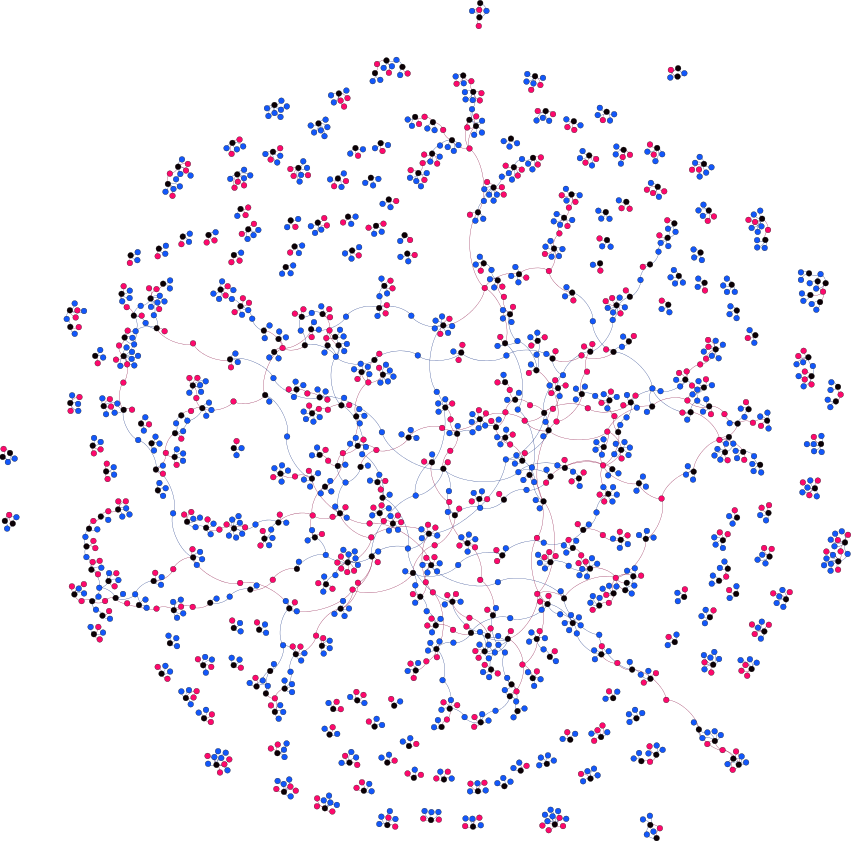

In [14]:
## For AARON: Not sure how to handle svg files, so put the png version of it below. You are free to change it.
## Also I do not have Gephi installed or understanding :) -- so leaving those magics for you too.
dis.Image('gviz.png')

            Plot of the entire 2 node network. Legend ~ Pink: Female, Blue: Male, Black: Company



Now let us project this 2-node network to it's component single node networks.

#### Company Network

### NEED YOUR THOUGHT AARON, MY GRAPHS BELOW ARE NOT HELPING ANYTHING

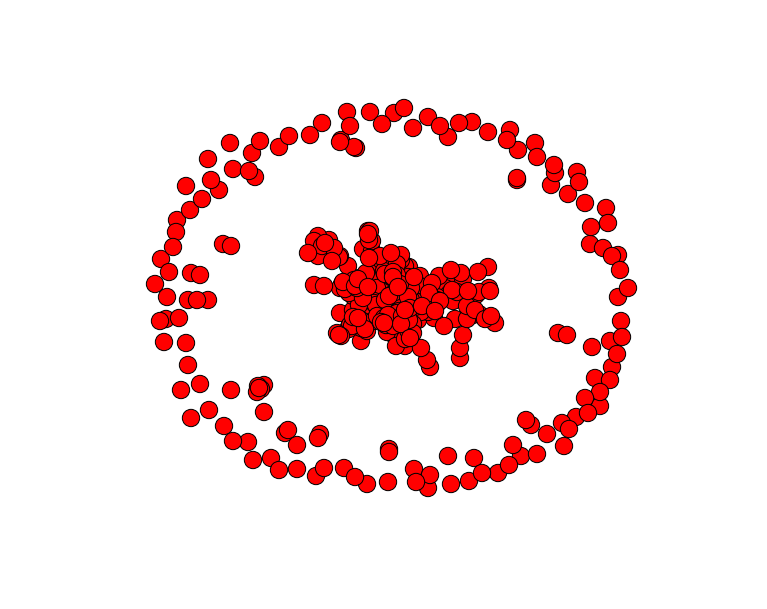

In [15]:
compNet=bi.weighted_projected_graph(g, comp, ratio=False)
nx.draw(compNet)
plt.show()

#### Person Network

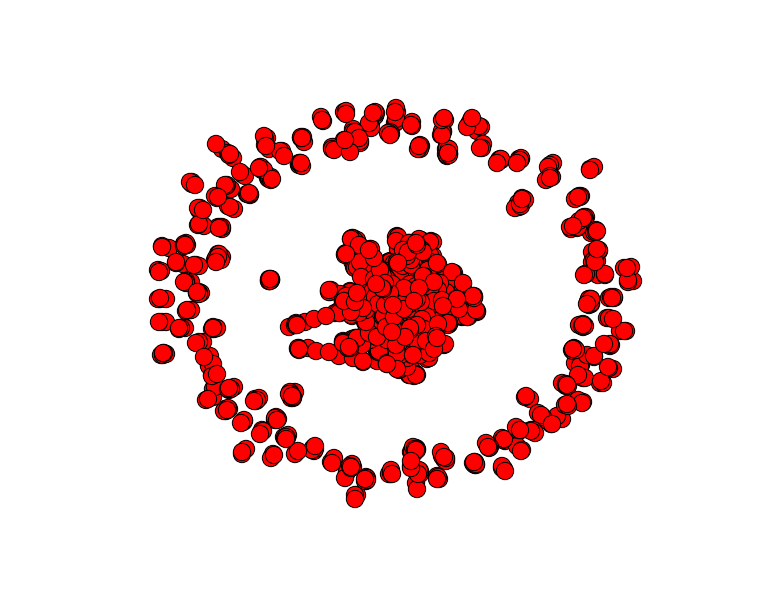

In [16]:
personNet=bi.weighted_projected_graph(g, pers, ratio=False)
nx.draw(personNet)
plt.show()

#### Conclusion